# 개인용 GPU에서 TRL로 SmolVLM DPO 파인튜닝하기

_작성자: [Sergio Paniego](https://github.com/sergiopaniego), 번역: [정우준](https://github.com/jungnerd)_

이번 레시피에서는 **TRL(Transformer Reinforcement Learning)** 라이브러리를 사용하여 **DPO(Direct Preference Optimization)** 방식으로 **🤏 smolVLM(Vision Language Model)**을 파인튜닝하는 방법을 알려드립니다. 이 레시피를 잘 익히신다면 개인용 GPU 환경에서도 사용자의 필요에 맞춰서 VLM을 조정할 수 있게 됩니다.

함께 **선호도 데이터셋**을 활용해서 [**SmolVLM**](https://huggingface.co/blog/smolvlm)이 우리가 원하는 형태의 대답을 출력할 수 있도록 파인튜닝해볼 예정입니다. SmolVLM은 성능도 뛰어나고 메모리 효율적인 모델로, 이 작업에 매우 적합합니다. 혹시 언어 모델이나 [비전-언어 모델](https://huggingface.co/blog/vlms)의 **선호도 최적화(Preference Optimization)** 개념이 처음이라면, [이 블로그 글](https://huggingface.co/blog/dpo_vlm)에 깊이 있게 개념 설명이 되어있으니 참고하세요.

우리가 사용할 데이터셋은 [HuggingFaceH4/rlaif-v_formatted](https://huggingface.co/datasets/HuggingFaceH4/rlaif-v_formatted)로, **`prompt + image`** 쌍과 함께 각각에 대한 **`chosen`(선택된)** 답변과 **`rejected`(거절된)** 답변이 포함되어 있습니다. 이 파인튜닝의 목표는 모델이 일관되게 **선택된 답변**을 선호하도록 해 환각 현상을 줄이는 것입니다.

이 레시피는 **NVIDIA L4 GPU**에서 테스트되었습니다.

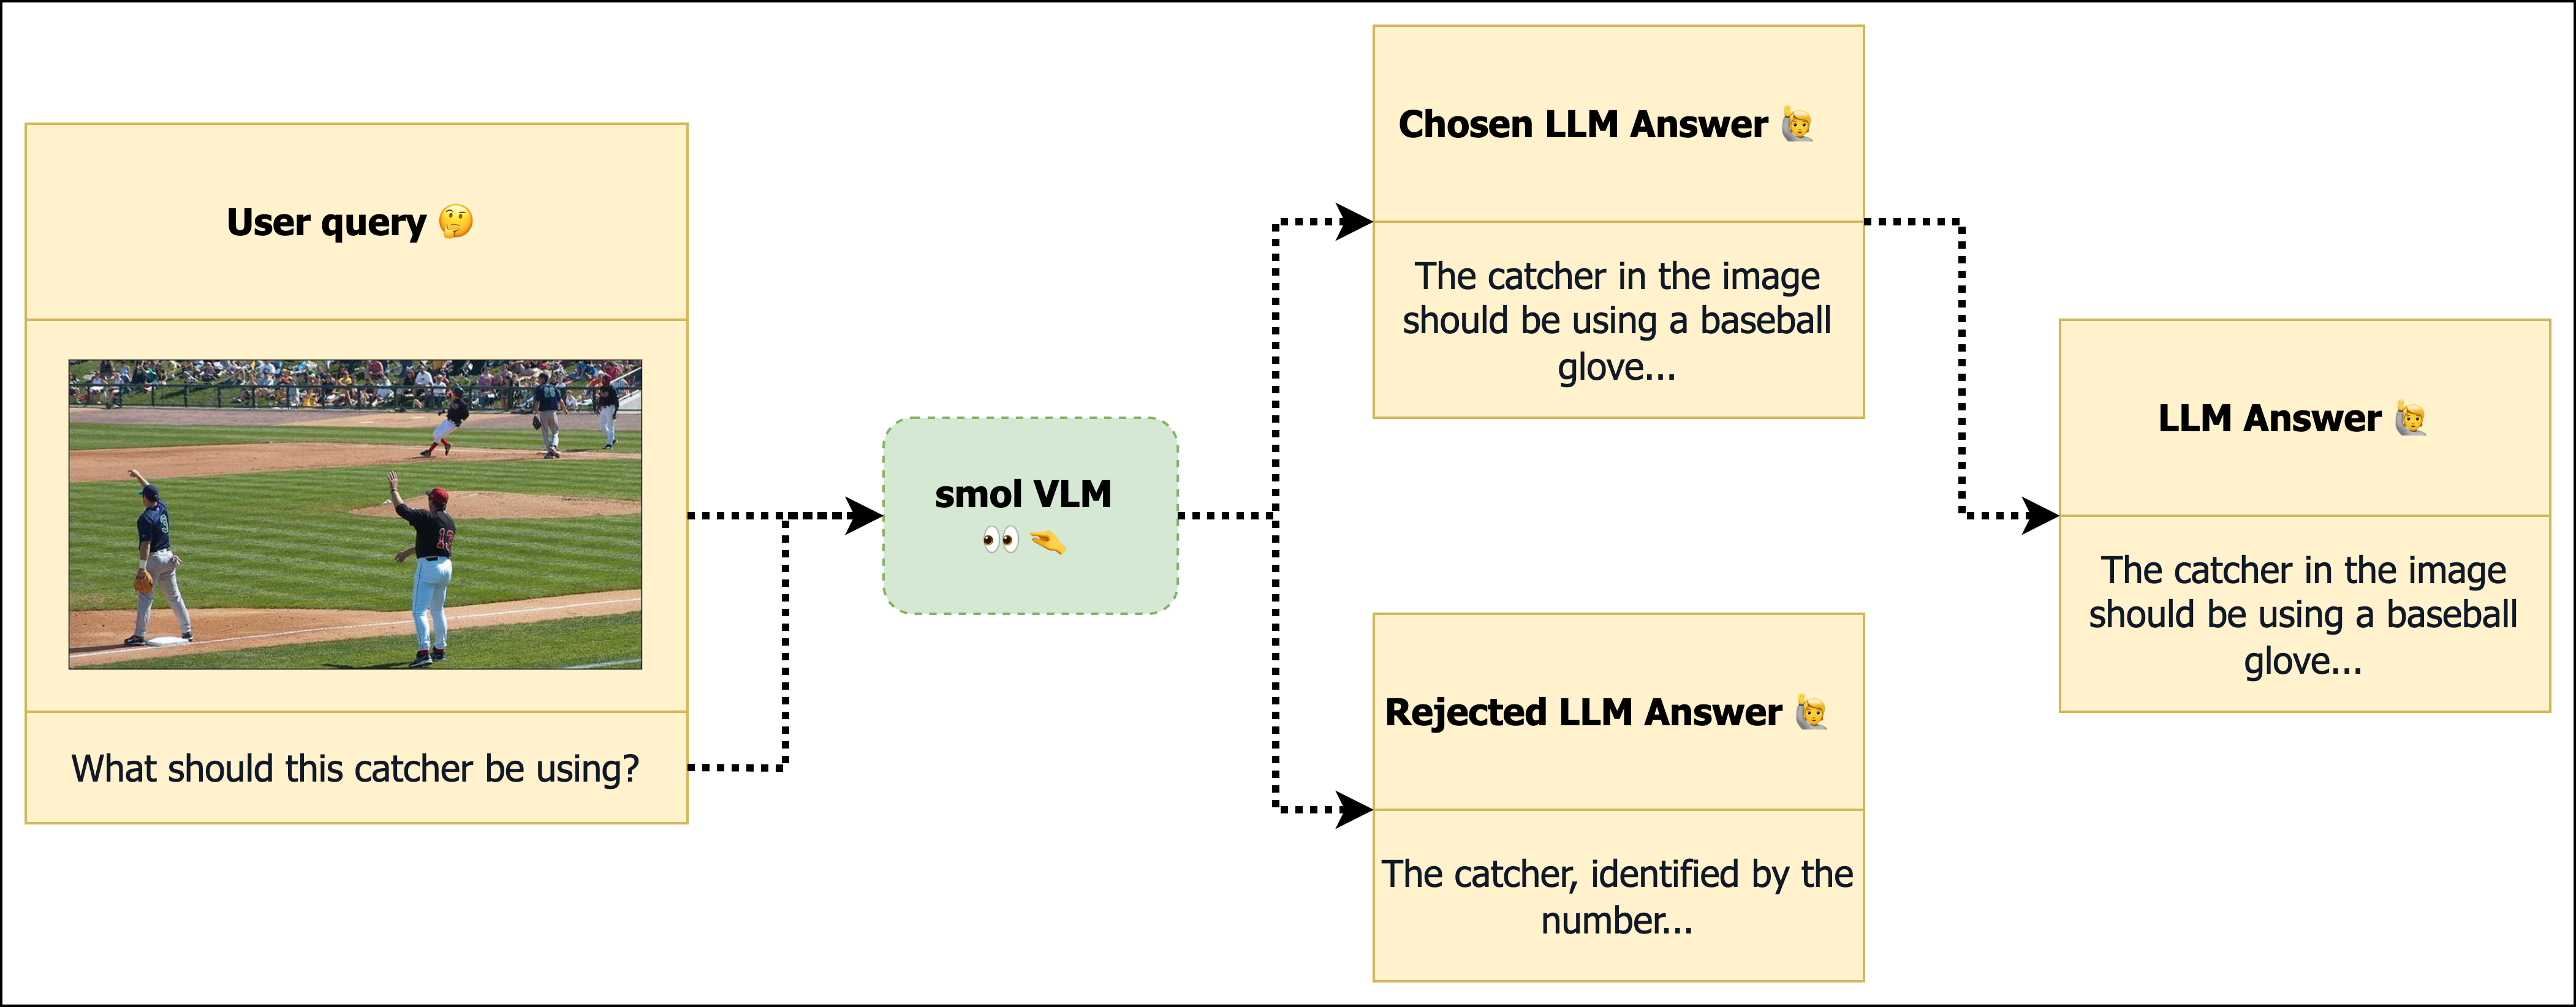

## 1. 필수 라이브러리 설치

파인튜닝을 위해 필요한 필수 라이브러리들을 먼저 설치해봅시다! 🚀

In [ ]:
!pip install  -U -q transformers trl datasets bitsandbytes peft accelerate
# Tested with transformers==4.46.3, trl==0.12.2, datasets==3.2.0, bitsandbytes==0.45.0, peft==0.14.0, accelerate==1.2.0

In [ ]:
!pip install -q flash-attn --no-build-isolation

Hugging Face 계정으로 로그인하면 이 노트북에서 직접 여러분의 모델을 저장하고 공유할 수 있습니다 🗝️.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. 데이터셋 불러오기 📁

이번 레시피에서 사용할 데이터셋은 [HuggingFaceH4/rlaif-v_formatted](https://huggingface.co/datasets/HuggingFaceH4/rlaif-v_formatted)입니다. 이 데이터셋은 각각의 **`prompt + image`** 쌍에 대해 **`chosen`**(선택된 정답)과 **`rejected`**(거절된 정답)을 함께 제공합니다. 이런 구조화된 형식은 **Direct Preference Optimization (DPO)** 방식의 학습에 매우 적합합니다.

이 데이터셋은 이미 해당 작업에 맞게 전처리되어 있습니다. 만약 여러분이 별도의 커스텀 데이터셋을 사용한다면, 동일한 형식으로 전처리해주어야 합니다.

이 예제에서는 전체 데이터셋 중 일부만 사용하여 과정을 설명할 예정입니다. 하지만 실제 환경에서는 더 나은 성능을 위해 전체 데이터셋을 활용하는 것이 좋습니다.

In [ ]:
from datasets import load_dataset

dataset_id = "HuggingFaceH4/rlaif-v_formatted"
train_dataset, test_dataset = load_dataset(dataset_id, split=['train[:6%]', 'test[:1%]'])

모든 이미지를 RGB 형식으로 변환하여 일관되도록 처리할 예정입니다:

In [ ]:
from PIL import Image

def ensure_rgb(example):
    # 이미지가 RGB 형식이 아니라면, RGB로 변환합니다.
    image = example['images'][0]
    if isinstance(image, Image.Image):
        if image.mode != 'RGB':
            image = image.convert('RGB')
        example['images'] = [image]
    return example

# 데이터셋에 변환을 적용합니다.
train_dataset = train_dataset.map(ensure_rgb, num_proc=32)
test_dataset = test_dataset.map(ensure_rgb, num_proc=32)

데이터셋의 구조와 우리가 다룰 데이터의 유형을 더 잘 이해하기 위해 예시 하나를 살펴보겠습니다.

In [ ]:
train_dataset[20]

{'chosen': [{'content': [{'text': "Yes, the grass in the image appears to be brown. This could indicate that the photo was taken during a dry season or in a region that experiences arid conditions. The brown grass contrasts with the grayish color of the elephant and provides a natural background that highlights the elephant's presence in its environment.",
     'type': 'text'}],
   'role': 'assistant'}],
 'rejected': [{'content': [{'text': 'Yes, the grass in the image appears to be brown. This could be due to a number of reasons such as the season (it might be a dry season), the type of grass, or the specific conditions of the environment where the photo was taken. The brown grass contrasts with the grayish color of the elephant and the white branches of the thorny tree, making it a prominent feature of the landscape.',
     'type': 'text'}],
   'role': 'assistant'}],
 'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>],
 'prompt': [{'content': [{'text': None, '

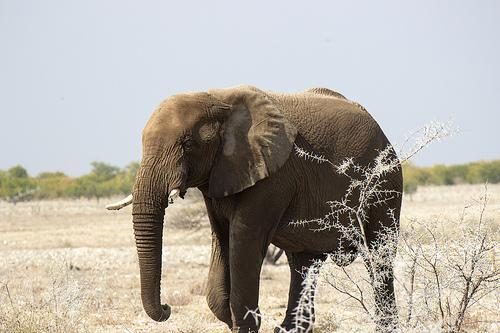

In [ ]:
train_dataset[20]['images'][0]

## 3. TRL을 사용해 모델 파인튜닝하기

### 3.1 학습을 위해 양자화된 모델 불러오기 ⚙️

먼저 `bitsandbytes`를 사용해 SmolVLM-Instruct 모델의 양자화된 버전을 불러오고, 함께 사용할 processor도 불러오겠습니다. 사용할 모델은 [SmolVLM-Instruct](https://huggingface.co/HuggingFaceTB/SmolVLM-Instruct)입니다.

In [ ]:
import torch
from transformers import Idefics3ForConditionalGeneration, AutoProcessor

model_id = "HuggingFaceTB/SmolVLM-Instruct"

In [ ]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 설정
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# 모델과 토크나이저 불러오기
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    _attn_implementation="flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_id)

### 3.2 QLoRA 및 DPOConfig 설정 🚀

이번 단계에서는 학습 환경을 구성하기 위해 [QLoRA](https://github.com/artidoro/qlora)를 설정합니다. **QLoRA**는 메모리 사용량을 줄이는 강력한 파인튜닝 기법으로, 제한된 하드웨어 환경에서도 대형 모델을 효율적으로 파인튜닝할 수 있게 해줍니다.

QLoRA는 기존의 **LoRA**(Low-Rank Adaptation) 기법을 기반으로 하며, 여기에 어댑터 가중치에 대한 양자화(quantization)를 도입합니다. 이로 인해 메모리 사용량이 크게 감소하고 훈련 속도도 빨라져, 자원이 제한된 환경에서 훌륭한 선택지가 됩니다.

In [ ]:
from peft import LoraConfig, get_peft_model

# LoRA 구성하기
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
    use_dora=True,
    init_lora_weights="gaussian"
)

# 모델에 PEFT 적용하기
peft_model = get_peft_model(model, peft_config)

# 학습가능한 파라미터 수 출력
peft_model.print_trainable_parameters()

trainable params: 11,269,248 || all params: 2,257,542,128 || trainable%: 0.4992


다음으로, `DPOConfig`를 사용하여 학습 옵션을 설정하겠습니다.

In [ ]:
from trl import DPOConfig

training_args = DPOConfig(
    output_dir="smolvlm-instruct-trl-dpo-rlaif-v",
    bf16=True,
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=32,
    num_train_epochs=5,
    dataset_num_proc=8,  # 토큰화는 8개 프로세스를 사용할 예정입니다.
    dataloader_num_workers=8,  # 데이터를 불러올 때 8개의 worker를 사용할 예정입니다.
    logging_steps=10,
    report_to="tensorboard",
    push_to_hub=True,
    save_strategy="steps",
    save_steps=10,
    save_total_limit=1,
    eval_steps=10,  # 평가를 수행할 스텝 간격
    eval_strategy="steps",
)

이번 단계에서는 [TRL 라이브러리](https://huggingface.co/docs/trl/index)의 [DPOTrainer](https://huggingface.co/docs/trl/dpo_trainer) 클래스를 사용해서 **Direct Preference Optimization (DPO)**를 위한 학습 인자를 정의합니다.

**DPO**는 레이블링된 선호도 데이터를 활용해, 모델이 더 나은 응답을 생성하도록 유도하는 학습 방식입니다. TRL의 [DPOTrainer](https://huggingface.co/docs/trl/dpo_trainer)는 학습 전에 **데이터셋을 토큰화** 하고 디스크에 저장합니다. 이 과정은 사용되는 데이터의 양에 따라 상당한 디스크 공간을 차지할 수 있으므로, 저장 공간을 미리 확보해 두는 것이 좋습니다.

이 단계는 시간이 다소 걸릴 수 있으니, 편하게 기다리며 과정을 즐겨보세요! 😄

In [ ]:
from trl import DPOTrainer

trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    tokenizer=processor,
)

자 이제 모델을 학습할 시간입니다! 🎉

In [ ]:
trainer.train()

결과를 저장해볼까요? 💾

In [ ]:
trainer.save_model(training_args.output_dir)

## 4. 파인튜닝된 모델 테스트해보기 🔍

우리의 비전-언어모델(VLM)의 파인튜닝이 완료되었으니, 이제 성능을 평가해볼까요? 이 섹션에서는 [HuggingFaceH4/rlaif-v_formatted](https://huggingface.co/datasets/HuggingFaceH4/rlaif-v_formatted) 데이터셋의 예제를 사용하여 모델을 테스트해보겠습니다. 결과를 살펴보면서 모델이 얼마나 선호되는 응답에 잘 맞춰 작동하는지 평가해봅시다! 🚀

시작하기에 앞서, 원활하고 최적화된 성능을 위해 GPU 메모리를 정리해줍시다. 🧹

In [ ]:
import gc
import time

def clear_memory():
    # 만약 전역 변수들이 있다면 삭제합니다
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # 가비지 컬렉션 수행 및 CUDA 메모리 정리
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 1.64 GB
GPU reserved memory: 2.01 GB


이전과 동일한 파이프라인을 사용하여 베이스 모델을 다시 로드하겠습니다.

In [ ]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2",
)

processor = AutoProcessor.from_pretrained(model_id)

훈련된 어댑터를 사전학습된 모델에 연결하겠습니다. 이 어댑터는 학습 중에 적용된 파인튜닝 조정을 포함하고 있어, 기본 모델의 핵심 파라미터를 변경하지 않으면서도 새로운 지식을 활용할 수 있게 해줍니다. 어댑터를 통합함으로써, 원래 모델 구조를 그대로 유지하면서 모델의 성능을 향상시킬 수 있습니다.

In [ ]:
adapter_path = "sergiopaniego/smolvlm-instruct-trl-dpo-rlaif-v" # 본인의 Hugging Face 계정 ID를 입력하세요!
model.load_adapter(adapter_path)

이제 모델이 처음 보는 예제를 활용해 평가해봅시다.

In [ ]:
test_dataset[20]

{'chosen': [{'content': [{'text': "In the image, there's a dynamic scene at what appears to be a beach or surfing location. The main focus is on a person skillfully riding a wave on a surfboard. This individual is dressed in a yellow shirt and seems to be enjoying the activity. In addition to the surfer, there are other elements in the scene such as waves breaking and creating white foam, indicating the active nature of the water. Nearby, there's another surfboard floating on the surface of the water, suggesting that more people might be participating in surfing or waiting for their turn. The overall atmosphere conveys a sense of fun, adventure, and connection with nature.",
     'type': 'text'}],
   'role': 'assistant'}],
 'rejected': [{'content': [{'text': 'In the image, there is a man enthusiastically surfing on a wave in the ocean. He is wearing a yellow shirt and short pants, adding a vibrant color contrast to the scene. The surfer is skillfully balancing himself on his surfboard 

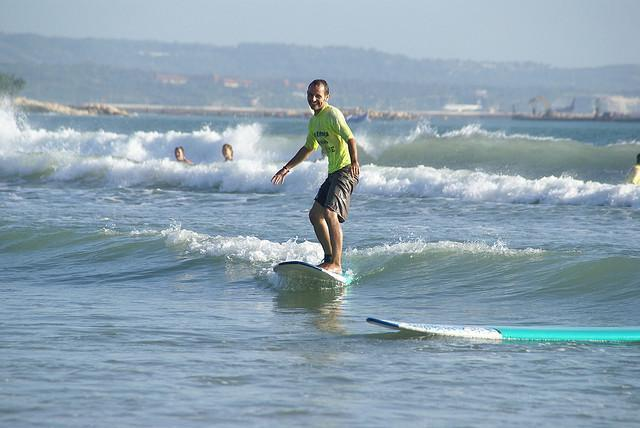

In [ ]:
test_dataset[20]['images'][0]

테스트 과정을 간소화하기 위해 다양한 샘플에 사용할 수 있는 공통 함수를 만들어보겠습니다. 이 함수는 각 샘플마다 코드를 반복해서 작성하지 않고도 모델의 성능을 효율적으로 평가할 수 있게 해줍니다. 재사용 가능한 함수를 통해 다양한 입력에 대해 모델이 얼마나 잘 작동하는지 빠르게 확인할 수 있습니다.

In [ ]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # 대화 템플릿을 적용한 텍스트 입력을 준비합니다
    text_input = processor.apply_chat_template(
        sample['prompt'],
        add_generation_prompt=True
    )

    image_inputs = []
    image = sample['images'][0]
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_inputs.append([image])

    # 모델에 넣을 입력값을 준비합니다
    model_inputs = processor(
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # 특정 device로 입력값을 옮깁니다

    # 모델로 텍스트를 생성합니다
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # 입력값의 인덱스를 제거하기 위해 생성된 인덱스를 잘라줍니다
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # 출력 텍스트를 디코딩해줍니다
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # 처음으로 디코딩된 출력 텍스트를 반환합니다

드디어 함수를 호출해서 모델을 평가할 준비가 되었습니다! 🚀

In [ ]:
output = generate_text_from_sample(model, processor, test_dataset[20])
output

" The image depicts a scene of a person surfing in the ocean. The central figure is a man standing on a surfboard, facing the camera with a joyful expression. He is wearing a bright green rash guard and dark-colored board shorts. The surfboard is white and blue, indicating it is a beginner-friendly board suitable for learning to surf.\n\nSurrounding the man, there are several other individuals in the water. Two people are visible in the background, swimming near the shore. The water is moderately choppy, with small waves breaking on the shore. The waves are white and foamy, indicating they are relatively small and gentle.\n\nIn the background, there is a distant coastline with a few buildings and structures visible. The sky is clear, with a few faint clouds visible. The overall setting appears to be a beach or coastal area, with the ocean and waves as the primary focus.\n\nThe image captures a moment of joy and accomplishment, as the surfer is enjoying the experience of surfing. The ma

이제 모델은 제공된 이미지와 프롬프트를 바탕으로 응답을 생성할 수 있습니다. 이러한 작업에서는 모델의 성능을 벤치마크와 비교해보는 것이 유용합니다. 이를 통해 얼마나 성능이 향상되었는지, 다른 모델들과 비교해 어느 정도 수준인지 확인할 수 있습니다. 비교 결과에 대한 더 자세한 내용은 [이 포스트](https://huggingface.co/blog/dpo_vlm#inference)를 참고하세요.

💻 모델을 테스트하기 위해 예제 애플리케이션을 개발해 두었습니다. 아래 링크에서 확인할 수 있습니다:
👉 [애플리케이션](https://huggingface.co/spaces/sergiopaniego/SmolVLM-trl-dpo-rlaif-v)

이 튜토리얼에서는 전체 데이터셋의 일부만 사용해 간단히 학습을 진행했기 때문에, 해당 Space에서는 Hugging Face의 공식 [DPO로 파인튜닝된 SmolVLM 모델](https://huggingface.co/HuggingFaceTB/SmolVLM-Instruct-DPO)을 활용했습니다. 모델 성능을 비교해보고 싶다면, 사전학습(pre-trained) 모델만을 사용하는 Space도 아래 링크에서 확인할 수 있습니다:
👉 [사전학습된 SmolVLM Space](https://huggingface.co/spaces/HuggingFaceTB/SmolVLM)

이 두 Space를 비교해 보면 파인튜닝이 모델 응답에 어떤 영향을 주는지 쉽게 확인할 수 있습니다.

In [1]:
from IPython.display import IFrame

IFrame(src="https://sergiopaniego-smolvlm-trl-dpo-rlaif-v.hf.space", width=1000, height=800)

## 5. 학습 여정을 이어가볼까요 🧑‍🎓️

비전 언어 모델 및 관련 도구들에 대한 지식을 확장하고 싶다면, 아래의 자료들을 참고해보세요:

- **[Hugging Face Cookbook 멀티모달 레시피](https://huggingface.co/learn/cookbook/index):** RAG(Retrieval-Augmented Generation) 파이프라인과 파인튜닝을 포함한 다양한 멀티모달 모델 실습 레시피들을 확인할 수 있습니다. 특히 이번 가이드를 보완해주는 [a recipe for fine-tuning a smol VLM with TRL using SFT](https://huggingface.co/learn/cookbook/fine_tuning_smol_vlm_sft_trl)도 함께 확인해보세요.

- **[TRL 커뮤니티 튜토리얼](https://huggingface.co/docs/trl/main/en/community_tutorials):** TRL의 내부 구조와 실제 응용 사례들을 다룬 다양한 커뮤니티 튜토리얼을 살펴볼 수 있습니다.

또한, [Fine-Tuning a Vision Language Model (Qwen2-VL-7B) with the Hugging Face Ecosystem (TRL)](https://huggingface.co/learn/cookbook/fine_tuning_vlm_trl) 문서의 _Continuing the Learning Journey_ 섹션도 참고하면 좋습니다.

이 자료들을 통해 멀티모달 학습 분야에 대한 이해를 한층 더 깊이 있게 확장할 수 있을 것입니다.